In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import folium

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE



In [2]:
sns.set_style('darkgrid')

In [3]:
df_values = pd.read_csv('data/values.csv')
df_labels = pd.read_csv('data/labels.csv')

df = pd.merge(df_values, df_labels, on='id')


# Business Problem

A nonprofit wants to improve access to water across Tanzania. To do so, the nonprofit wants to be able to send alerts to the entities in charge of an individual to check the status of said well. These alerts will be sent when a well is deemed 'in need of repair' or 'non-functioning'. With this goal in mind, the nonprofit needs an algorithm that can accurately predict when the wells should be checked. 

# SCRUBBING

In [4]:
df.drop('id', axis=1, inplace=True)

In [5]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

#### Null Values

Dropping null values results in the loss of approx 10,000 entries

I will one-hot-encode 'null columns' for the features that contain these null values during preproccessing (Modeling Phase)

#### Dropping Columns

In [6]:
df.drop('scheme_name', axis=1, inplace=True)

In [7]:
df.drop('subvillage', axis=1, inplace=True)

In [8]:
df.drop('waterpoint_type_group', axis=1, inplace=True)

In [9]:
df.drop('quantity_group', axis=1, inplace=True)

In [10]:
df.drop('water_quality', axis=1, inplace=True)

In [11]:
df.drop('payment', axis=1, inplace=True)

1. **Dropped Columns:** 
    - scheme_name (over half of values are null)
    - subvillage (too many unique string values. Better geographical data exists)
    - waterpoint_type_group (redundant)
    - quantity_group (redundant)
    - payment (redundant)
    - water_quality (redundant)

#### Grouping Low-Frequency Values 

In [12]:
df = df.replace({'funder': 'Ministry Of Water'}, 'Government Of Tanzania')

series = pd.value_counts(df['funder'])
mask = (series/series.sum() * 100).lt(1.75)
df['funder'] = np.where(df['funder'].isin(series[mask].index),'Other',df['funder'])

df = df.replace({'funder': '0'}, 'Other')

In [13]:
df['funder'].value_counts()

Other                     34462
Government Of Tanzania     9674
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Name: funder, dtype: int64

<AxesSubplot:xlabel='count', ylabel='funder'>

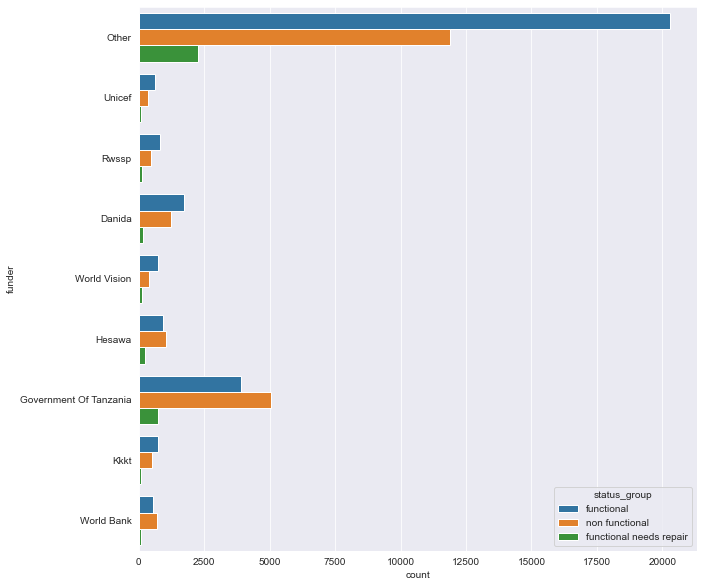

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(y='funder', hue='status_group', data=df)

In [15]:
# groupby_test = df.groupby('funder').agg('count').reset_index()
# groupby_test.head()
# sns.barplot(x='status_group', y='funder', data=groupby_test[groupby_test['status_group'] > 1000])


I have strong reason to believe that 'Government of Tanzania' and 'Ministry of Water' can be lumped into one: https://en.wikipedia.org/wiki/Ministry_of_Water_and_Irrigation

In [16]:
#aggregating
df = df.replace({'installer': 'hesawa'}, 'HESAWA')
df = df.replace({'installer': 'Central government'}, 'Government')
df = df.replace({'installer': 'Commu'}, 'Community')

#cleaning 
df = df.replace({'installer': 'DANID'}, 'DANIDA' )

In [17]:
series = pd.value_counts(df['installer'])
mask = (series/series.sum() * 100).lt(1.75)
df['installer'] = np.where(df['installer'].isin(series[mask].index),'Other',df['installer'])
df['installer'].value_counts()

df = df.replace({'installer': '0'}, 'Other')

In [18]:
df['installer'].value_counts()

Other         31475
DWE           17402
Government     2447
Community      1613
DANIDA         1602
RWE            1206
Name: installer, dtype: int64

<AxesSubplot:xlabel='count', ylabel='installer'>

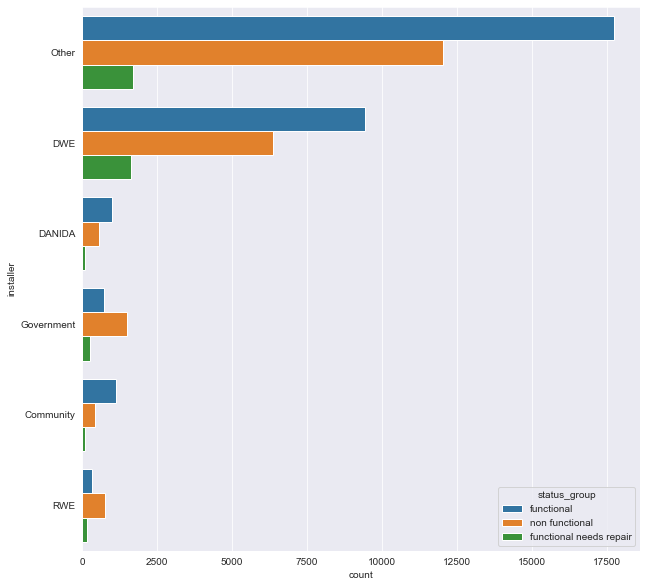

In [19]:
plt.figure(figsize=(10,10))
sns.countplot(y='installer', hue='status_group', data=df)

The following values have been aggregated due to the belief that they were entered with spelling errors

In [20]:
#aggregating
df = df.replace({'wpt_name': 'Shuleni'}, 'School')
df = df.replace({'wpt_name': 'Shule'}, 'School')
df = df.replace({'wpt_name': 'Shule Ya Misingi'}, 'School')

series = pd.value_counts(df['wpt_name'])
mask = (series/series.sum() * 100).lt(1.55)
df['wpt_name'] = np.where(df['wpt_name'].isin(series[mask].index),'Other',df['wpt_name'])

df = df.replace({'wpt_name': 'none'}, 'Other')

In [21]:
df['wpt_name'].value_counts()

Other     57292
School     2108
Name: wpt_name, dtype: int64

<AxesSubplot:xlabel='count', ylabel='wpt_name'>

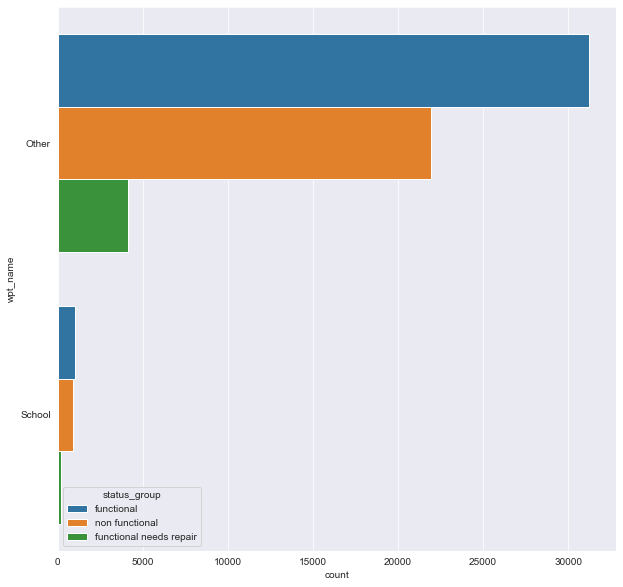

In [22]:
plt.figure(figsize=(10,10))
sns.countplot(y='wpt_name', hue='status_group', data=df)

#### construction_year (missing values)

In [23]:
sorted(df['construction_year'].unique())

[0,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

#### well_age

Before I bin the construction_year feature, I am going to make use of what information is given to calculate the age of each well 

In [24]:
df['well_age'] = 2013 - df['construction_year']
df = df.replace({'well_age': 2013}, 100 )

#### binning construction_year

In [25]:
df[(df['construction_year'] < 1970)]['construction_year'].value_counts().sum() - 20709

538

In [26]:
df[(df['construction_year'] < 1980) & (df['construction_year'] > 1969)]['construction_year'].value_counts().sum()

4406

In [27]:
df[(df['construction_year'] < 1990) & (df['construction_year'] > 1979)]['construction_year'].value_counts().sum()

5578

In [28]:
df[(df['construction_year'] < 2000) & (df['construction_year'] > 1989)]['construction_year'].value_counts().sum()

7678

In [29]:
df[(df['construction_year'] < 2010) & (df['construction_year'] > 2000)]['construction_year'].value_counts().sum()

13239

In [30]:
df[(df['construction_year'] >= 2010)]['construction_year'].value_counts().sum()

5161

**OBSERVATION**
1. Nearly half of the entries are missing a construction year
2. Construction year goes back consistantly to 1960
    - I will bin construction years and create a 'null' column during preprocessing
    - BINS = 1960 - 1989, 1990-199, 2000-2009, 2010+

In [31]:
# bins=[-1,1959,1989,1999,2009,2014]

# df['year_constructed']= pd.cut(df['construction_year'],
#                               bins=bins,
#                               labels= ['Unknown','60s - 80s', '1990s', '2000s', '2010+'])

# df.drop('construction_year', axis=1, inplace=True)

#### Assessing Geographic Data

- subvillage 
- region 
- region_code 
- district_code
- lga
- ward 

In [32]:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [33]:
df['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [34]:
len(df['region'].unique()) - len(df['region_code'].unique())

-6

In [35]:
df['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [36]:
len(df['district_code'].unique()) - len(df['region'].unique())

-1

In [37]:
df['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [38]:
df['ward'].value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
                   ... 
Mwanga Kaskazini      1
Rasbura               1
Kitete                1
Simbay                1
Chinugulu             1
Name: ward, Length: 2092, dtype: int64

Based upon value counts, it would appear that 'region' will be the cleanest geographical data to work with 

#### Continuous Data

In [39]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,well_age
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,45.406162
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,41.190108
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,9.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,27.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,100.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,100.000000


#### Dealing with Population

In [40]:
df[(df['population'] == 0)]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,management_group,payment_type,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group,well_age
4,0.0,2011-07-13,Other,0,Other,31.130847,-1.825359,School,0,Lake Victoria,...,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,100
6,0.0,2012-10-01,Other,0,Other,33.362410,-3.766365,Other,0,Internal,...,user-group,never pay,good,enough,machine dbh,borehole,groundwater,hand pump,non functional,100
7,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Other,0,Lake Tanganyika,...,user-group,unknown,milky,enough,shallow well,shallow well,groundwater,hand pump,non functional,100
8,0.0,2012-11-03,Other,0,Other,32.711100,-5.146712,Other,0,Lake Tanganyika,...,user-group,never pay,salty,seasonal,machine dbh,borehole,groundwater,hand pump,non functional,100
9,0.0,2011-08-03,Other,0,Other,30.626991,-1.257051,Other,0,Lake Victoria,...,user-group,never pay,good,enough,shallow well,shallow well,groundwater,hand pump,functional,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,0.0,2011-07-10,Other,0,Other,30.667805,-2.483710,Other,0,Lake Victoria,...,user-group,never pay,good,insufficient,spring,spring,groundwater,communal standpipe,non functional,100
59392,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Other,0,Lake Rukwa,...,user-group,never pay,good,enough,spring,spring,groundwater,communal standpipe,non functional,100
59393,0.0,2012-10-27,Other,0,Other,33.866852,-4.287410,Other,0,Internal,...,commercial,per bucket,good,insufficient,dam,dam,surface,other,functional,100
59397,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Other,0,Rufiji,...,user-group,monthly,fluoride,enough,machine dbh,borehole,groundwater,hand pump,functional,100


In [41]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

Nearly half the data for 'population' is 0 and 1 

My best option is to bin 

In [42]:
#df[(df['population'] < 100) & (df['population'] > 1)]

In [43]:
#df[(df['population'] < 500) & (df['population'] > 1)]

In [44]:
#df[(df['population'] < 200) & (df['population'] > 1)]

In [45]:
#df[(df['population'] > 200) ]

In [46]:
# bins = [-1,1,199,30501]
# df['population_grouped'] = pd.cut(df['population'],
#                                  bins=bins,
#                                  labels=['Unknown', '<200', '>200'])

#### gps_height (Altitude)

In [47]:
df['altitude'] = df['gps_height']
df.drop('gps_height', axis=1, inplace=True)

<AxesSubplot:xlabel='altitude', ylabel='Count'>

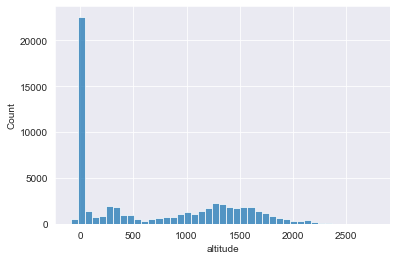

In [48]:
sns.histplot(df['altitude'])

**OBSERVATION**
1. While 0 is an acceptable value for altitude, I do not believe that there are this many wells at an altitude of 0

#### Month Recorded 

Tanzania experiences its wetest season in March/April, and its driest during June/July/August 

The month the status of the well was recorded could be revealing 

In [49]:
df['month_recorded']=pd.to_datetime(df['date_recorded']).dt.month
df['year_recorded']=pd.to_datetime(df['date_recorded']).dt.year


In [50]:
df.drop('date_recorded', axis=1, inplace=True)

In [51]:
df = df[(df['year_recorded']) > 2005]

## Revisitin Null Values 

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59369 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59369 non-null  float64
 1   funder                 55736 non-null  object 
 2   installer              55716 non-null  object 
 3   longitude              59369 non-null  float64
 4   latitude               59369 non-null  float64
 5   wpt_name               59369 non-null  object 
 6   num_private            59369 non-null  int64  
 7   basin                  59369 non-null  object 
 8   region                 59369 non-null  object 
 9   region_code            59369 non-null  int64  
 10  district_code          59369 non-null  int64  
 11  lga                    59369 non-null  object 
 12  ward                   59369 non-null  object 
 13  population             59369 non-null  int64  
 14  public_meeting         56041 non-null  object 
 15  re

In [53]:
df.dropna(inplace=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48630 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             48630 non-null  float64
 1   funder                 48630 non-null  object 
 2   installer              48630 non-null  object 
 3   longitude              48630 non-null  float64
 4   latitude               48630 non-null  float64
 5   wpt_name               48630 non-null  object 
 6   num_private            48630 non-null  int64  
 7   basin                  48630 non-null  object 
 8   region                 48630 non-null  object 
 9   region_code            48630 non-null  int64  
 10  district_code          48630 non-null  int64  
 11  lga                    48630 non-null  object 
 12  ward                   48630 non-null  object 
 13  population             48630 non-null  int64  
 14  public_meeting         48630 non-null  object 
 15  re

In [55]:
df['source_type'].value_counts()

spring                  14979
shallow well            12409
borehole                 9733
river/lake               9109
rainwater harvesting     1605
dam                       581
other                     214
Name: source_type, dtype: int64

In [56]:
df['source_class'].value_counts()

groundwater    37121
surface        11295
unknown          214
Name: source_class, dtype: int64

In [57]:
df['source'].value_counts()

spring                  14979
shallow well            12409
machine dbh              8955
river                    8504
rainwater harvesting     1605
hand dtw                  778
lake                      605
dam                       581
other                     182
unknown                    32
Name: source, dtype: int64

In [58]:
df.drop('source_type', axis=1, inplace=True)

In [59]:
df['payment_type'].value_counts()

never pay     20771
per bucket     8112
monthly        7542
unknown        4169
on failure     3640
annually       3468
other           928
Name: payment_type, dtype: int64

In [60]:
df['management_group'].value_counts()

user-group    43633
commercial     3045
parastatal     1330
other           548
unknown          74
Name: management_group, dtype: int64

In [61]:
df['extraction_type'].value_counts()

gravity                      23159
nira/tanira                   6259
other                         4537
submersible                   3753
swn 80                        2857
mono                          2499
india mark ii                 2045
afridev                       1346
ksb                           1330
other - rope pump              212
other - swn 81                 199
windmill                       104
cemo                            89
india mark iii                  86
other - play pump               76
walimi                          46
climax                          32
other - mkulima/shinyanga        1
Name: extraction_type, dtype: int64

In [62]:
df['extraction_type_group'].value_counts()

gravity            23159
nira/tanira         6259
submersible         5083
other               4537
swn 80              2857
mono                2499
india mark ii       2045
afridev             1346
other handpump       322
rope pump            212
other motorpump      121
wind-powered         104
india mark iii        86
Name: extraction_type_group, dtype: int64

In [63]:
df.drop('extraction_type', axis=1, inplace=True)

In [64]:
df['extraction_type_class'].value_counts()

gravity         23159
handpump        12915
submersible      5083
other            4537
motorpump        2620
rope pump         212
wind-powered      104
Name: extraction_type_class, dtype: int64

In [65]:
df['scheme_management'].value_counts()

VWC                 32681
WUG                  4237
Water authority      2919
WUA                  2634
Water Board          2489
Parastatal           1293
Company              1028
Private operator      804
Other                 376
SWC                    97
Trust                  71
None                    1
Name: scheme_management, dtype: int64

In [66]:
df['recorded_by'].value_counts()

GeoData Consultants Ltd    48630
Name: recorded_by, dtype: int64

In [67]:
df.drop('recorded_by', axis=1, inplace=True)

In [68]:
len(df['ward'].unique())

1875

In [69]:
df.drop('ward', axis=1, inplace=True)

In [70]:
df['lga'].value_counts()

Njombe           2454
Moshi Rural      1226
Arusha Rural     1173
Kilosa           1057
Kasulu           1039
                 ... 
Tarime             39
Ilala              36
Ileje              27
Singida Rural      17
Nyamagana           1
Name: lga, Length: 118, dtype: int64

In [71]:
df.drop('lga', axis=1, inplace=True)

# EDA

In [72]:
df.describe()

,amount_tsh,longitude,latitude,num_private,region_code,district_code,population,construction_year,well_age,altitude,month_recorded,year_recorded
count,48630.000000,48630.000000,4.863000e+04,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000
mean,357.870952,34.230648,-5.703317e+00,0.548262,14.684598,5.730393,175.389595,1332.920193,44.104668,696.445157,4.318857,2011.899712
std,2818.635008,6.309842,2.860211e+00,13.244462,17.199136,9.665276,471.061012,940.708415,40.767786,698.813656,2.992206,0.944249
min,0.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,1.000000,2011.000000
25%,0.000000,33.050844,-8.219467e+00,0.000000,5.000000,2.000000,0.000000,0.000000,8.000000,0.000000,2.000000,2011.000000
50%,0.000000,35.265112,-5.017793e+00,0.000000,12.000000,3.000000,30.000000,1986.000000,27.000000,452.000000,3.000000,2011.000000
75%,50.000000,37.338478,-3.337886e+00,0.000000,17.000000,5.000000,200.000000,2005.000000,100.000000,1332.000000,7.000000,2013.000000
max,250000.000000,40.323402,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,100.000000,2770.000000,12.000000,2013.000000


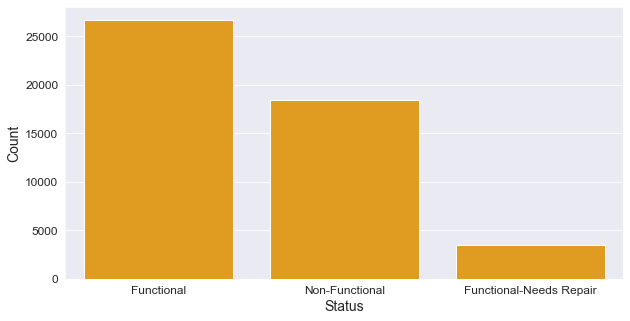

In [73]:
fig, ax = plt.subplots(figsize=(10,5))


imbalance_plot= sns.countplot(ax=ax,
              x='status_group', 
              data=df,
             color = 'orange')

plt.xticks([0,1,2], 
           ['Functional', 'Non-Functional', 'Functional-Needs Repair'],
          fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(xlabel='Status', fontsize=14)
plt.ylabel(ylabel='Count', fontsize=14);


**OBSERVATION**
1. There are far more functional wells than non-functional / needs repair
2. I will need to address the class imbalances during preprocessing / modeling 

<AxesSubplot:xlabel='status_group', ylabel='amount_tsh'>

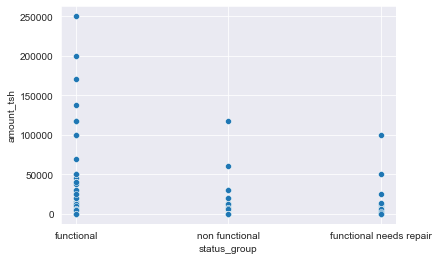

In [74]:
sns.scatterplot(x='status_group', y='amount_tsh', data=df)

In [75]:
tsh_df = df

In [76]:
tsh_df = tsh_df[(tsh_df['amount_tsh'] < 150000)]

<AxesSubplot:xlabel='status_group', ylabel='amount_tsh'>

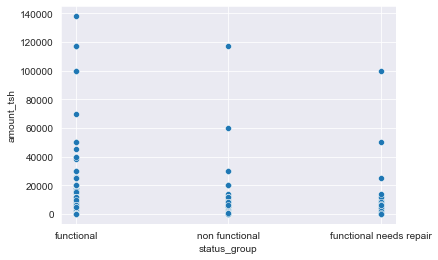

In [77]:
sns.scatterplot(x='status_group', y='amount_tsh', data=tsh_df)

**OBSERVATION**
1. It would appear that higher amounts of static head correlates with being functional; however it is very likely that this is due to the class imbalance


<AxesSubplot:xlabel='count', ylabel='funder'>

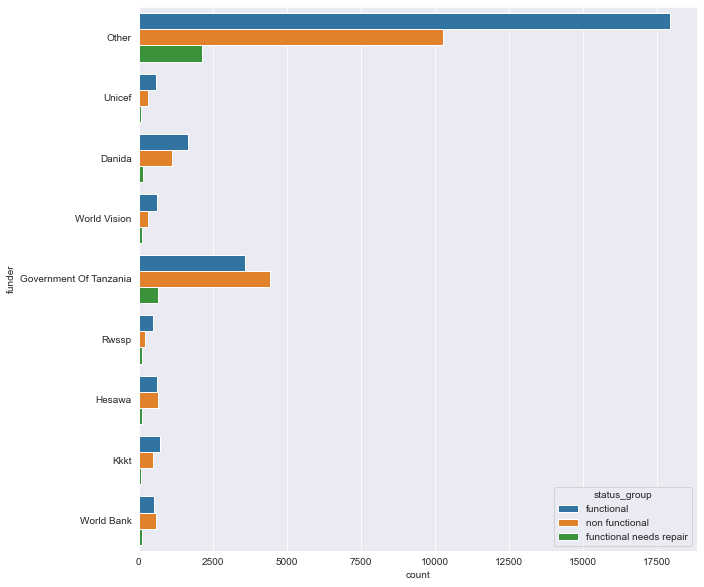

In [78]:
plt.figure(figsize=(10,10))
sns.countplot(y='funder', hue='status_group', data=df)

In [79]:
df.drop('funder', axis=1, inplace=True)

<AxesSubplot:xlabel='count', ylabel='installer'>

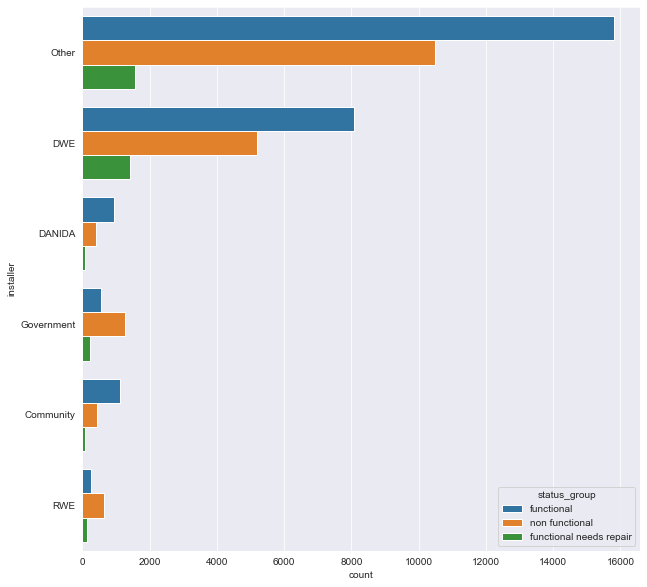

In [80]:
plt.figure(figsize=(10,10))
sns.countplot(y='installer', hue='status_group', data=df)

In [81]:
df.drop('installer', axis=1, inplace=True)

<AxesSubplot:xlabel='count', ylabel='management_group'>

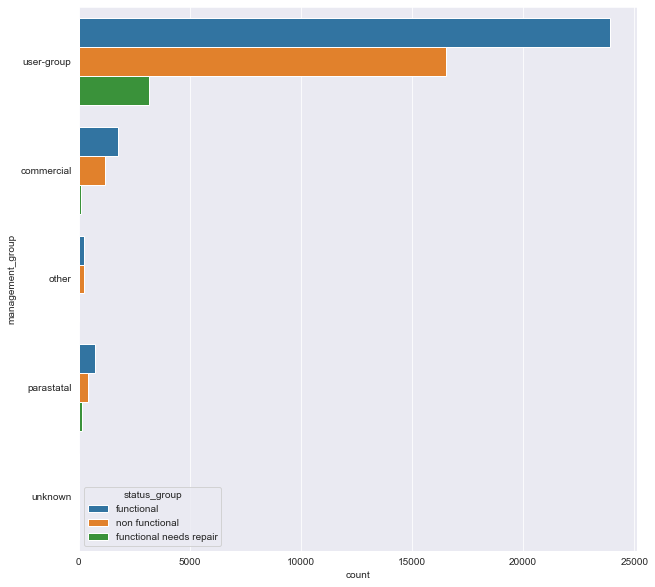

In [82]:
plt.figure(figsize=(10,10))
sns.countplot(y='management_group', hue='status_group', data=df)

<AxesSubplot:xlabel='count', ylabel='management'>

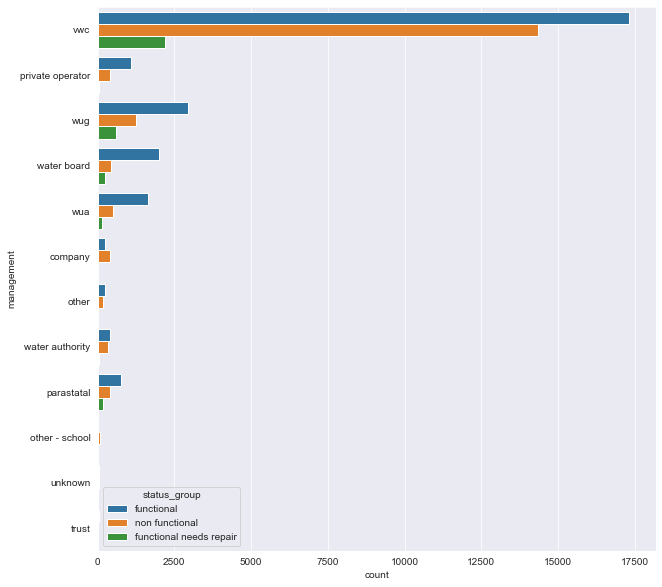

In [83]:
plt.figure(figsize=(10,10))
sns.countplot(y='management', hue='status_group', data=df)

In [84]:
df.drop('management',axis=1, inplace=True)

<AxesSubplot:xlabel='status_group', ylabel='population'>

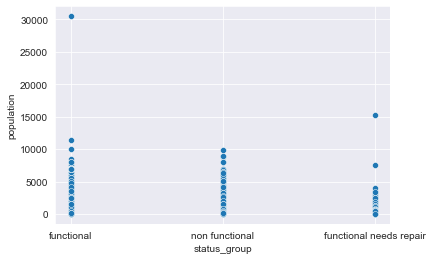

In [85]:
sns.scatterplot(x='status_group', y='population', data=df)

In [86]:
df.groupby('status_group').population.median()

status_group
functional                 40
functional needs repair    50
non functional              1
Name: population, dtype: int64

**OBSERVATION**
1. small populations may correlate with non-functional wells, as it may be more imperative that resources are spent on more populous wells 
2. functional wells may have a slightly smaller associated population due to less frequent use 

<AxesSubplot:xlabel='status_group', ylabel='altitude'>

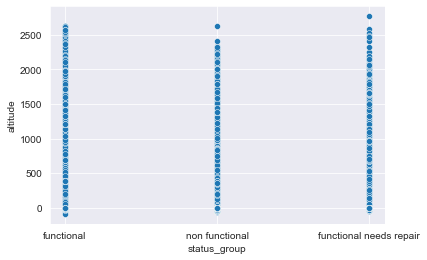

In [87]:
sns.scatterplot(x='status_group', y='altitude', data=df)

In [88]:
age_df = df[(df['well_age'] < 100)]

<AxesSubplot:xlabel='status_group', ylabel='well_age'>

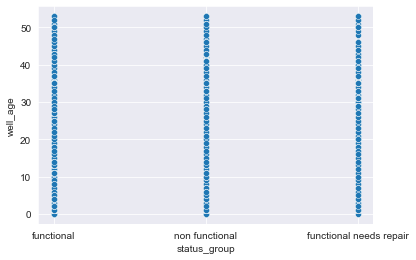

In [89]:
sns.scatterplot(x='status_group', y='well_age', data=age_df)

<AxesSubplot:xlabel='count', ylabel='well_age'>

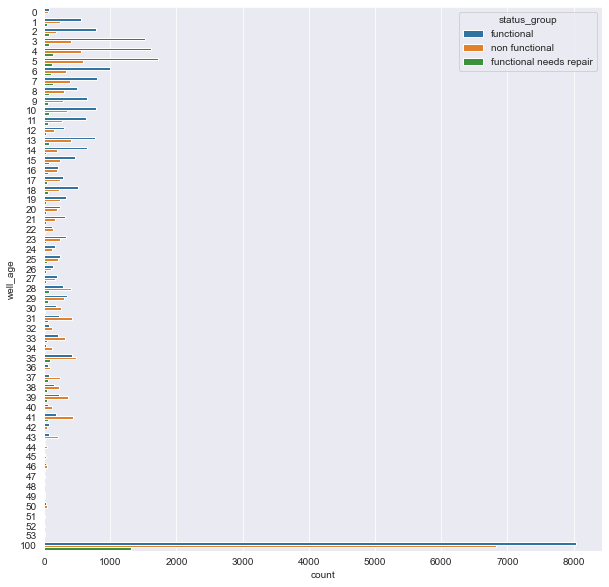

In [90]:
plt.figure(figsize=(10,10))
sns.countplot(y='well_age', hue='status_group', data=df)

**OBSERVATION**
1. there are typically more non-functional wells than functional wells for wells 28 years and over 

In [91]:
df[(df['population'] > 20000)]['region']

30537    Tanga
Name: region, dtype: object

Tanga is a large port city in the NorthEast of Tanzania, this datapoint could make sense
https://en.wikipedia.org/wiki/Tanga,_Tanzania

<AxesSubplot:xlabel='count', ylabel='month_recorded'>

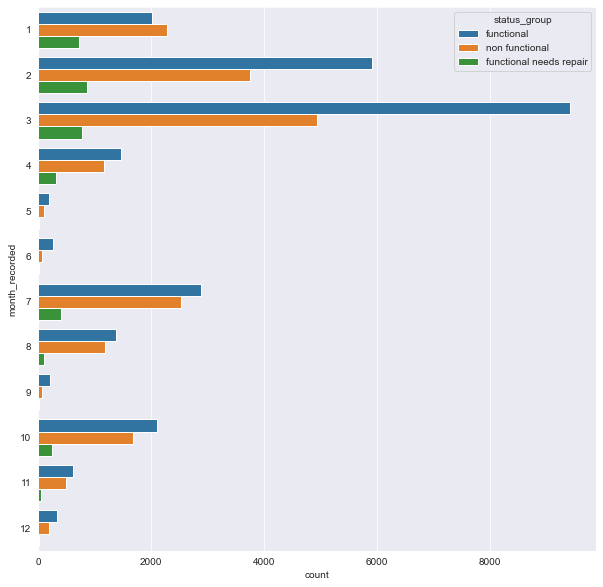

In [92]:
plt.figure(figsize=(10,10))
sns.countplot(y='month_recorded', hue='status_group', data=df)

**OBSERVATION**
1. most of the data collected is collected in the first quarter of the year (Jan - March)
2. May, July, September, and December seem to have very little recordings 
3. June - October are the driest seasons: it would appear that there is a spike in recordings halfway through the dry season

<AxesSubplot:xlabel='count', ylabel='year_recorded'>

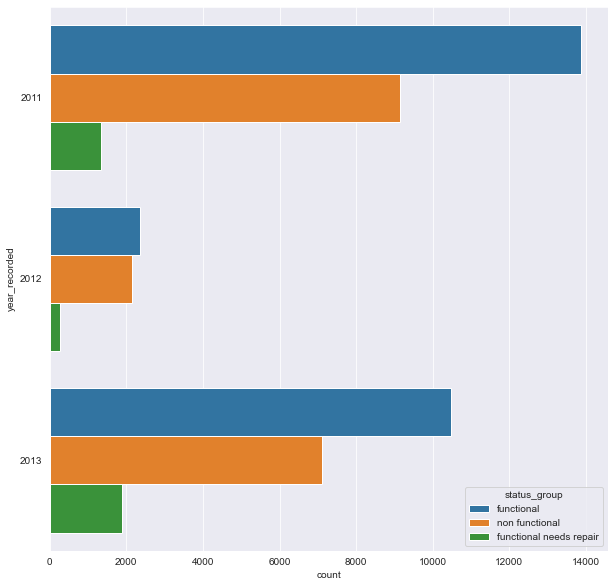

In [93]:
plt.figure(figsize=(10,10))
sns.countplot(y='year_recorded', hue='status_group', data=df)

In [94]:
df.drop('year_recorded', axis=1, inplace=True)

<AxesSubplot:xlabel='count', ylabel='quality_group'>

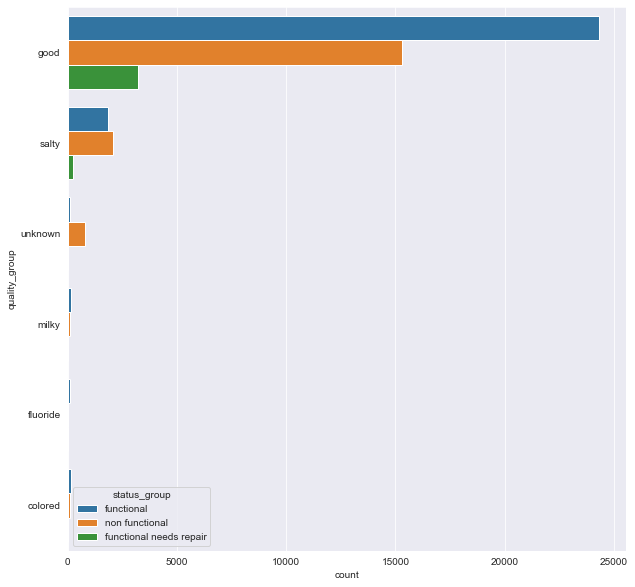

In [95]:
plt.figure(figsize=(10,10))
sns.countplot(y='quality_group', hue='status_group', data=df)

In [96]:
quality_df = df[(df['quality_group'] != 'good')]

<AxesSubplot:xlabel='count', ylabel='quality_group'>

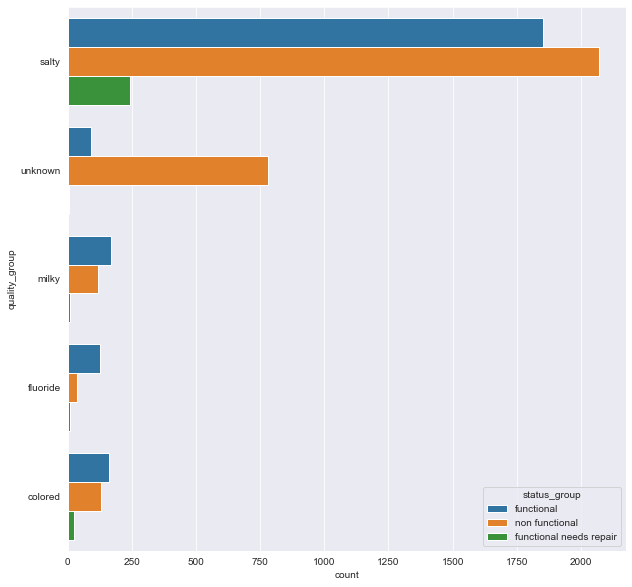

In [97]:
plt.figure(figsize=(10,10))
sns.countplot(y='quality_group', hue='status_group', data=quality_df)

<AxesSubplot:xlabel='count', ylabel='quantity'>

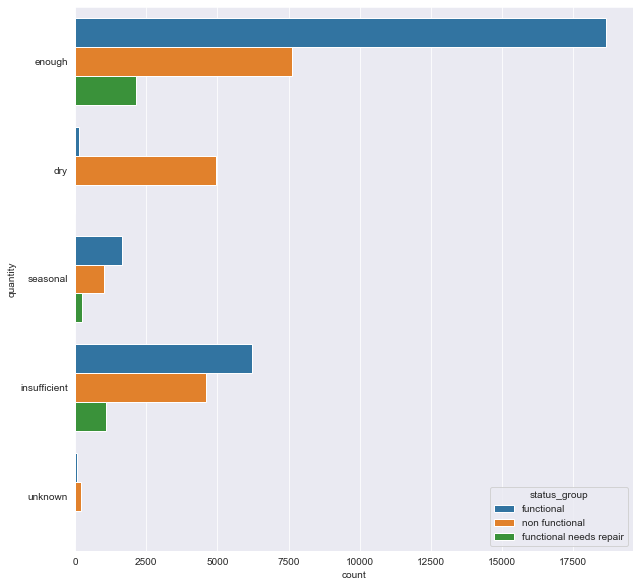

In [98]:
plt.figure(figsize=(10,10))
sns.countplot(y='quantity', hue='status_group', data=df)

<AxesSubplot:xlabel='count', ylabel='basin'>

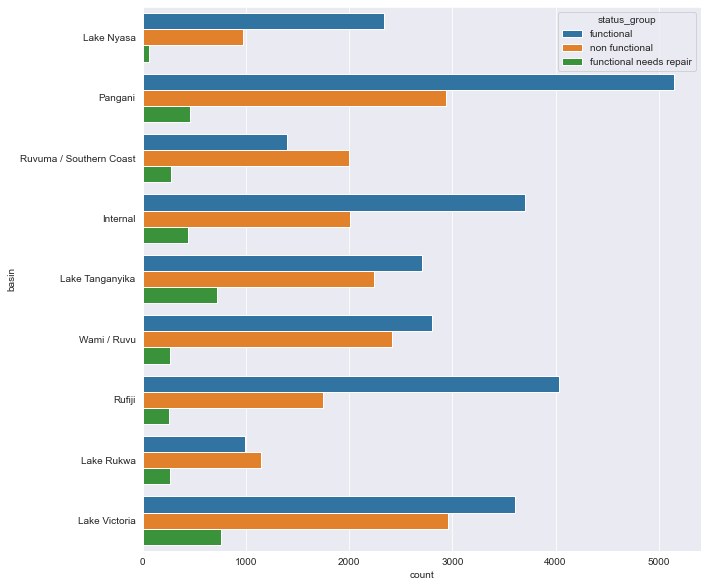

In [99]:
plt.figure(figsize=(10,10))
sns.countplot(y='basin', hue='status_group', data=df)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48630 entries, 0 to 59399
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             48630 non-null  float64
 1   longitude              48630 non-null  float64
 2   latitude               48630 non-null  float64
 3   wpt_name               48630 non-null  object 
 4   num_private            48630 non-null  int64  
 5   basin                  48630 non-null  object 
 6   region                 48630 non-null  object 
 7   region_code            48630 non-null  int64  
 8   district_code          48630 non-null  int64  
 9   population             48630 non-null  int64  
 10  public_meeting         48630 non-null  object 
 11  scheme_management      48630 non-null  object 
 12  permit                 48630 non-null  object 
 13  construction_year      48630 non-null  int64  
 14  extraction_type_group  48630 non-null  object 
 15  ex

<AxesSubplot:xlabel='count', ylabel='scheme_management'>

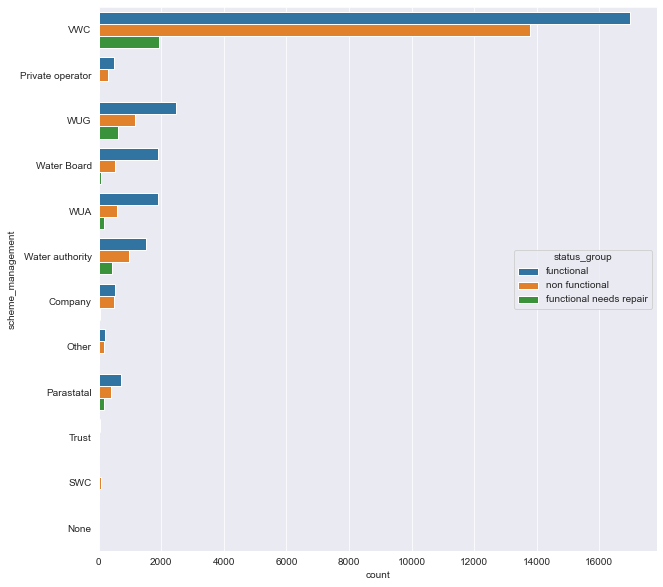

In [101]:
plt.figure(figsize=(10,10))
sns.countplot(y='scheme_management', hue='status_group', data=df)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

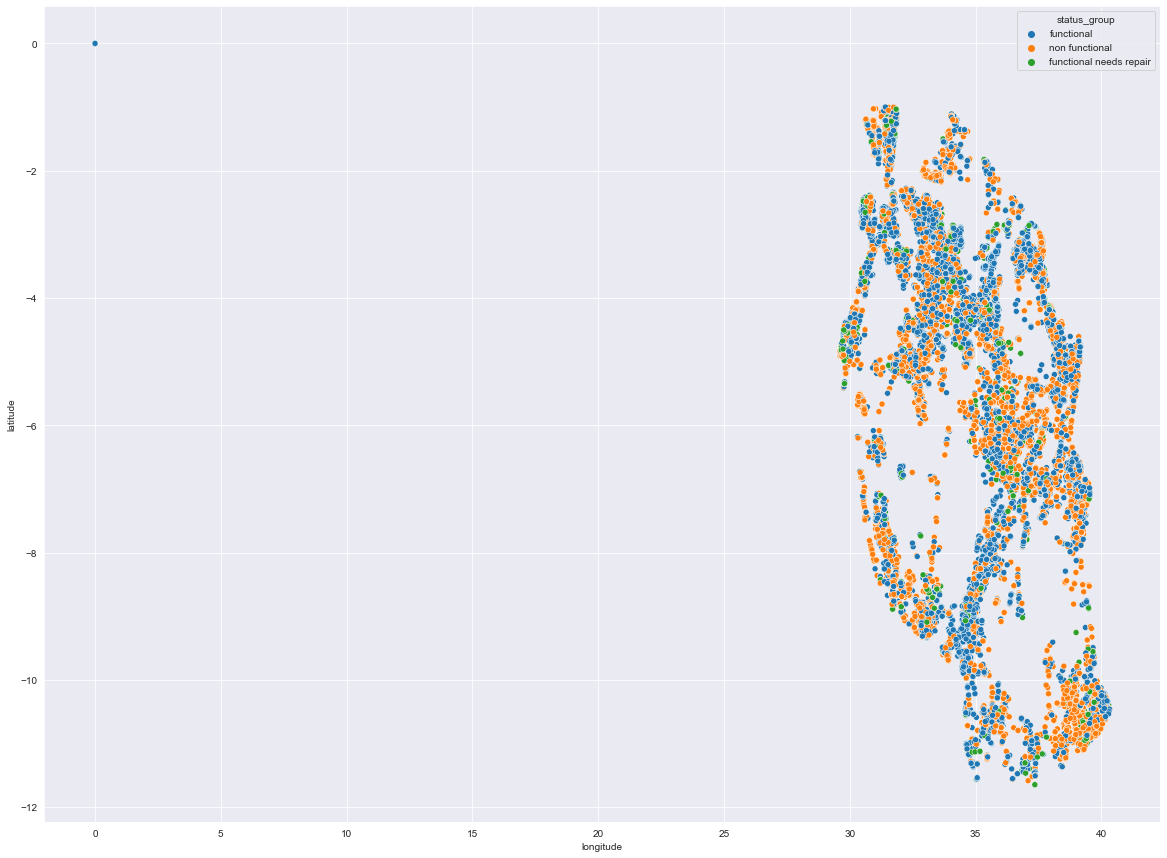

In [102]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=df)

In [103]:
df.describe()

,amount_tsh,longitude,latitude,num_private,region_code,district_code,population,construction_year,well_age,altitude,month_recorded
count,48630.000000,48630.000000,4.863000e+04,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000,48630.000000
mean,357.870952,34.230648,-5.703317e+00,0.548262,14.684598,5.730393,175.389595,1332.920193,44.104668,696.445157,4.318857
std,2818.635008,6.309842,2.860211e+00,13.244462,17.199136,9.665276,471.061012,940.708415,40.767786,698.813656,2.992206
min,0.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,1.000000
25%,0.000000,33.050844,-8.219467e+00,0.000000,5.000000,2.000000,0.000000,0.000000,8.000000,0.000000,2.000000
50%,0.000000,35.265112,-5.017793e+00,0.000000,12.000000,3.000000,30.000000,1986.000000,27.000000,452.000000,3.000000
75%,50.000000,37.338478,-3.337886e+00,0.000000,17.000000,5.000000,200.000000,2005.000000,100.000000,1332.000000,7.000000
max,250000.000000,40.323402,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,100.000000,2770.000000,12.000000


In [104]:
df[df['longitude'] == 0]

,amount_tsh,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,population,...,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,well_age,altitude,month_recorded
53,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Mwanza,19,6,0,...,unknown,unknown,dry,machine dbh,groundwater,communal standpipe multiple,non functional,100,0,8
168,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Shinyanga,17,1,0,...,other,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,100,0,1
256,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Mwanza,19,6,0,...,never pay,unknown,dry,machine dbh,groundwater,hand pump,non functional,100,0,7
301,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Mwanza,19,6,0,...,never pay,good,insufficient,machine dbh,groundwater,hand pump,functional,100,0,7
306,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Mwanza,19,6,0,...,never pay,good,insufficient,machine dbh,groundwater,hand pump,functional,100,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59135,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Mwanza,19,6,0,...,never pay,good,enough,shallow well,groundwater,hand pump,functional,100,0,8
59158,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Shinyanga,17,1,0,...,never pay,good,enough,shallow well,groundwater,hand pump,functional,100,0,7
59189,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Shinyanga,17,1,0,...,other,good,enough,shallow well,groundwater,hand pump,functional needs repair,100,0,7
59295,0.0,0.0,-2.000000e-08,Other,0,Lake Victoria,Shinyanga,17,1,0,...,never pay,good,enough,shallow well,groundwater,hand pump,functional needs repair,100,0,7


In [105]:
df = df[df['longitude'] > 0]

In [106]:
map_df = df

In [107]:
map_df = map_df[(map_df['longitude'] > 0)]

In [108]:
map_df[(map_df['longitude'] == 0)]

,amount_tsh,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,population,...,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,well_age,altitude,month_recorded


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

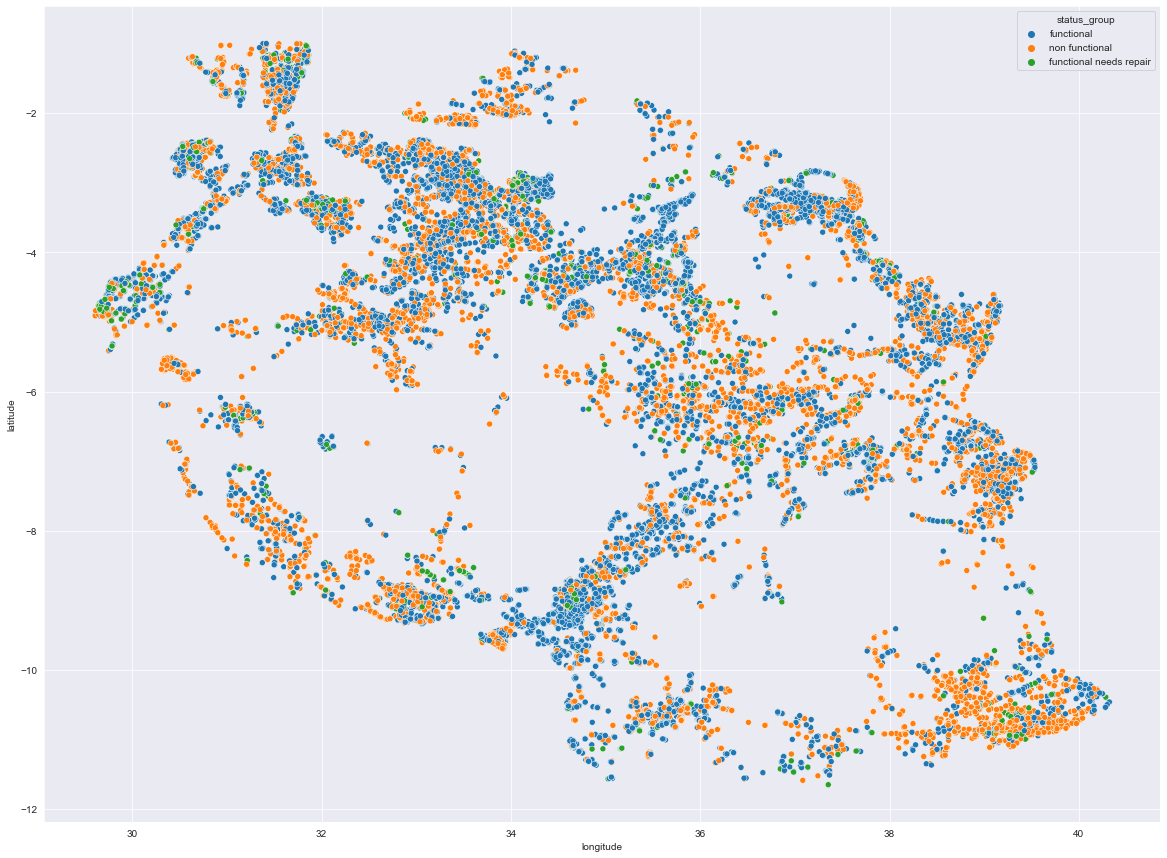

In [109]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=map_df)

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='basin', data=map_df)

In [ ]:
df

# Modeling 


In [111]:
df = df.replace({'status_group': 'functional'}, 1)
df = df.replace({'status_group': 'non functional'}, 2)
df = df.replace({'status_group': 'functional needs repair'}, 3)

### Logistic Regression - Baseline 

In [112]:
#splitting features and target
#creating dummy variables for categorical data
X = df.drop('status_group', axis=1)
X = pd.get_dummies(X, drop_first=True )

y = df['status_group']

In [113]:
#creating training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state=2)

In [114]:
#scaling 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Decision Tree Baseline 

In [115]:
dt_base = DecisionTreeClassifier()

dt_base_model = dt_base.fit(X_train_scaled, y_train)

In [116]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
# tree.plot_tree(dt_base,
#                feature_names = X.columns, 
#                class_names=np.unique(y).astype('str'),
#                filled = True)
# plt.show()

In [117]:
print(classification_report(y_train, dt_base.predict(X_train_scaled)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     19656
           2       1.00      1.00      1.00     13455
           3       1.00      1.00      1.00      2367

    accuracy                           1.00     35478
   macro avg       1.00      1.00      1.00     35478
weighted avg       1.00      1.00      1.00     35478



In [118]:
print(classification_report(y_test, dt_base.predict(X_test_scaled)))

              precision    recall  f1-score   support

           1       0.80      0.80      0.80      6471
           2       0.77      0.77      0.77      4562
           3       0.35      0.37      0.36       793

    accuracy                           0.76     11826
   macro avg       0.64      0.64      0.64     11826
weighted avg       0.76      0.76      0.76     11826



In [119]:
print(dt_base.tree_.max_depth)

41


**INTERPRETATION**
1. Extremely Overfit. The model knows the training data completely 

In [120]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (20,15), dpi=300)
tree.plot_tree(dt_base,
               feature_names = X.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

KeyboardInterrupt: 

**OBSERVATION**
1. The long tails indicate the overfitting

In [ ]:
plot_confusion_matrix(dt_base, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. 2/3 is worst case scenario (predicted non functional, but is actually in need of repair)
2. 3/1 is pretty bad (predicted in need of repair, but is actually working) 

## Decision Tree - Gridsearch

In [121]:
dt_v2 = DecisionTreeClassifier()

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 0.5, 2: 3, 3: 10}
weight_dict3 = {1: 0.25, 2: 6, 3: 12}

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'class_weight': [weight_dict, weight_dict2, weight_dict3, 'balanced'],
    'max_depth' : [10, 20, 30],
    'min_samples_split' : [1.0, 3, 5],
    'min_samples_leaf' : [10, 15, 30]
}

dt_v2_model = GridSearchCV(estimator = dt_v2, param_grid=param_grid, cv=3)
dt_v2_model.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [ ]:
print(dt_v2_model.best_params_)

In [ ]:
print(classification_report(y_train, dt_v2_model.predict(X_train_scaled)))

In [ ]:
plot_confusion_matrix(dt_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, dt_v2_model.predict(X_test_scaled)))

In [ ]:
dt_v3 = DecisionTreeClassifier(criterion= 'entropy')

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 0.5, 2: 1.5, 3: 8}

param_grid = {
    'class_weight': [weight_dict, weight_dict2],
    'max_depth' : [25, 30, 35],
    'min_samples_split' : [3, 5],
    'min_samples_leaf' : [9, 10, 11]
}

dt_v3_model = GridSearchCV(estimator = dt_v3, param_grid=param_grid, cv=3)
dt_v3_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v3_model.best_params_)

In [ ]:
plot_confusion_matrix(dt_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, dt_v3_model.predict(X_test_scaled)))

In [ ]:
dt_v4 = DecisionTreeClassifier(criterion= 'entropy', max_depth=30)

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 1, 2: 3, 3: 10}

param_grid = {
    'class_weight': [weight_dict, weight_dict2],
    'min_samples_split' : [2, 3],
    'min_samples_leaf' : [7, 8, 9]
}

dt_v4_model = GridSearchCV(estimator = dt_v4, param_grid=param_grid, cv=3)
dt_v4_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v4_model.best_params_)

In [ ]:
print(classification_report(y_test, dt_v4_model.predict(X_test_scaled)))

### Decision Tree - SMOTE

Thus far I have onl been dealing with class imbalance by adjusting 'class_weight' in gridsearch. While this is a valid technique, I am seeing little improvement. Using SMOTE to create new synthetic data, rather than simply giving more weight to the minority classes (2 and 3), might yield useful insight.

In [ ]:
#creating training and testing data
# X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size= .25, random_state=2)

In [ ]:
sm = SMOTE(random_state=2)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [ ]:
#scaling 
scaler = StandardScaler()

X_train_scaled_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [ ]:
dt_smote_base = DecisionTreeClassifier()
dt_smote_base_model = dt_smote_base.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(classification_report(y_train_sm, dt_smote_base_model.predict(X_train_scaled_sm)))

In [ ]:
print(classification_report(y_test, dt_smote_model.predict(X_test_scaled)))

In [ ]:
print(dt_smote_model.tree_.max_depth)

### Decision Tree - Smote(2)

In [ ]:
dt_smote_v2 = DecisionTreeClassifier()


param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [10, 20, 25],
    'min_samples_split' : [1.0, 10, 20, 30],
    'min_samples_leaf' : [5, 10, 15]
}

dt_smote_v2_model = GridSearchCV(estimator = dt_smote_v2, param_grid=param_grid, cv=3)
dt_smote_v2_model.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(dt_smote_v2_model.best_params_)

In [ ]:
print(classification_report(y_train_sm, dt_smote_v2_model.predict(X_train_scaled_sm)))

In [ ]:
print(classification_report(y_test, dt_smote_v2_model.predict(X_test_scaled)))

### Decision Tree - SMOTE (3)

In [ ]:
dt_smote_v4 = DecisionTreeClassifier(max_depth=25, min_samples_leaf=5, min_samples_split=10)

In [ ]:
dt_smote_v4.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(classification_report(y_train_sm, dt_smote_v4.predict(X_train_scaled_sm)))

In [ ]:
print(classification_report(y_test, dt_smote_v4.predict(X_test_scaled)))

**INTERPRETATION**
1. 3 is still extremely overfit, but other classes are performing okay (still some overfitting)
2. Looking at overall performance across all classes, this is my best Decision Tree
3. Even after using SMOTE, my model is still bad at predicting 3 (the minority class).
    - experimenting with class weights provided no significant breakthroughs
    - Knowing this, there may be specific features that make predicting the minority class very difficult, so RandomForest may be able to address this 

## Random Forest - Baseline 

In [ ]:
forest_base = RandomForestClassifier()
forest_base_model = forest_base.fit(X_train_scaled, y_train)

In [ ]:
print(classification_report(y_train, forest_base_model.predict(X_train_scaled)))

In [ ]:
print(classification_report(y_test, forest_base_model.predict(X_test_scaled)))

In [ ]:
max_depth = []
for classifier in forest_base_model:
    max_depth.append(classifier.tree_.max_depth)
    

In [ ]:
import statistics as stat
stat.median(max_depth)

**INTERPRETATION**
1. Completely overfit, just like the Decision Tree basemodel 
2. Max depth has increased from 30(decisiontree base model) to 40

## Random Forest v2

**REASONING**
1. Thus far overfitting has been the largest obstacle for my DecisionTree models and my RandomForest basemodel 
2. To address this, I am going to set the RandomForest parameters to values that will discourage overfitting (small max_depth, large min_sample_split, etc.) 

In [ ]:
forest_v2 = RandomForestClassifier()

weight_dict = {1: 0.5, 2: 3, 3: 10}
weight_dict2 = {1: 0.25, 2: 6, 3: 12}

param_grid= {
    'criterion': ['gini', 'entropy'],
    'class_weight': [weight_dict, weight_dict2],
    'max_depth': [25, 30, 35], 
    'min_samples_split': [10, 15, 20],
    # trying to abide by the MSL should be at least 2xMSS
    'min_samples_leaf': [20, 25, 30],
    ,
    #approx 6 seems to be the optimum number of features to consider
    # https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
    
    
}

forest_v2_model = GridSearchCV(estimator = forest_v2, param_grid=param_grid, cv=3)
forest_v2_model.fit(X_train_scaled, y_train)

# Merging 2 and 3

Thus far, performance for many of my models have been decent at predicting if a well is functioning, or not functioning, but has been terrible at correctly predicting if a well is functioning but needs repair 
1. This can be attributed to the massive class imbalance 
    - A wide variety of different balancing measures (class_weights and SMOTE), and hyperparameter tuning for deciiontrees and randomforests have not been able to achieve a recall of over 50% for functioning-needs repair
2. To account for this I will merge 'nonfunctioning' and 'functioning-needs repair' 
    - Classifying funcitioning-needs repair as nonfunctioning is acceptable, as a repair team will be able to either fix a nonfunctioning well, or make repairs to a well that could  become nonfunctioning in the future 

In [126]:
df_binary = df.replace({'status_group': 3}, 2) 

In [127]:
df_binary['status_group'].value_counts()

1    26127
2    21177
Name: status_group, dtype: int64

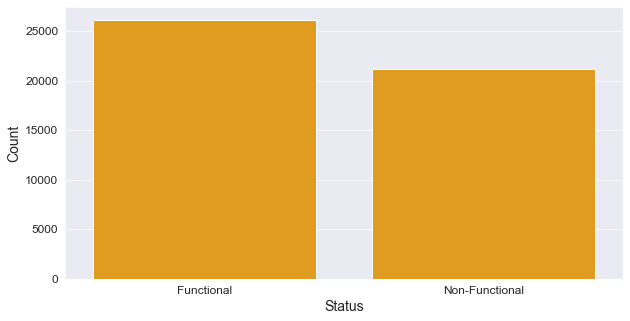

In [128]:
fig, ax = plt.subplots(figsize=(10,5))


imbalance_plot= sns.countplot(ax=ax,
              x='status_group', 
              data=df_binary,
             color = 'orange')

plt.xticks([0,1], 
           ['Functional', 'Non-Functional'],
          fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(xlabel='Status', fontsize=14)
plt.ylabel(ylabel='Count', fontsize=14)
plt.savefig('images/binary_count');


This has alleviated the class imbalance tremendously 

In [133]:
#splitting features and target
#creating dummy variables for categorical data
X = df_binary.drop('status_group', axis=1)
X = pd.get_dummies(X, drop_first=True )

y = df_binary['status_group']

#creating training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state=42)


#scaling 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Decision Tree - Baseline

In [ ]:
dt_base = DecisionTreeClassifier()

dt_base_model = dt_base.fit(X_train_scaled, y_train)

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(dt_base,
               feature_names = X.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [ ]:
print(classification_report(y_train, dt_base.predict(X_train_scaled)))

In [ ]:
dt_base.tree_.max_depth

In [ ]:
print(classification_report(y_test, dt_base.predict(X_test_scaled)))

In [ ]:
plot_confusion_matrix(dt_base, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Training is completely overfit (to be exptected)
2. FP and FN are nearly identical... does this mean the model is guessing 50/50?


## Decision Tree v2 (Gridsearch)

In [ ]:
dt_v2 = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
    'max_depth' : [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 20, 30],
}

dt_v2_model = GridSearchCV(estimator = dt_v2, param_grid=param_grid, cv=3)
dt_v2_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v2_model.best_params_)

In [ ]:
print(classification_report(y_train, dt_v2_model.predict(X_train_scaled)))

In [ ]:
print(classification_report(y_test, dt_v2_model.predict(X_test_scaled)))

In [ ]:
plot_confusion_matrix(dt_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Accuracy remains the same as basemodel
2. recall for Functioning improved
3. recall for Nonfunctioning has dropped by 4%
4. False Negatives are higher - worst case 

## Decision Tree v3 - LAST TREE

**INTENTIONS**
1. I will be weighting 'nonfunctioning' slightly more and 'functioning' slightly less to see if FN will drop 

In [ ]:
dt_v3 = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_split=10)

weight_dict = {1: 0.75, 2: 1.25}
weight_dict2= {1: 0.9, 2: 1.1}

param_grid = {
    'class_weight': [weight_dict, weight_dict2],
    'min_samples_leaf': [5, 7, 10],
}

dt_v3_model = GridSearchCV(estimator = dt_v3, param_grid=param_grid, cv=3)
dt_v3_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v3_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, dt_v3_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, dt_v3_model.predict(X_test_scaled)))

plot_confusion_matrix(dt_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Adjusting class weights slightly in favor of nonfunctional had a very minimal decrease in FN
2. Recall for nonfunctinoal has increased by 3%, sacrificing 3% recall for functional 


### Best Decision Tree = dt_v3_model
- Accuracy : 79%
- Nonfunctional Recall : 75%
- Nonfunctional F1: 76%

# Random Forest - Baseline 

1. I am expecting RandomForest models to have an improvement in performance due to ###########
2. Viewing feature importance will be a helpful insight 

In [ ]:
forest_base = RandomForestClassifier()
forest_base_model = forest_base.fit(X_train_scaled, y_train)

In [ ]:
print(classification_report(y_train, forest_base_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, forest_base_model.predict(X_test_scaled)))

plot_confusion_matrix(forest_base_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
max_depth_base = []
for classifier in forest_base_model:
    max_depth_base.append(classifier.tree_.max_depth)

stat.median(max_depth_base)

In [ ]:
def plot_feature_importances_base(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


In [ ]:
plot_feature_importances_base(forest_base_model)

**INTERPRETATION**
1. Performance is nearly identical to the DecisionTree basemodel
    - Completely overfit
    - this gives me little faith that RandomForest will help provide optimal results

## RandomForest v2 (Gridsearch)

In [ ]:
forest_v2 = RandomForestClassifier()

param_grid= {
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
    'max_depth': [25, 30, 35], 
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [20, 25, 30],    
}

forest_v2_model = GridSearchCV(estimator = forest_v2, param_grid=param_grid, cv=3)
forest_v2_model.fit(X_train_scaled, y_train)

In [ ]:
print(forest_v2_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, forest_v2_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, forest_v2_model.predict(X_test_scaled)))

plot_confusion_matrix(forest_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Surprisingly, this model does not produce much better results than the best decisiontree model 
    - 79% accuracy for both 
2. Most importantly, FN are much worse
    - nonfunctional recall has dropped 8%

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.best_estimator_.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


In [ ]:
plot_feature_importances(forest_v2_model)

## Random Forest v3

**INTENTIONS**
1. All models have been favoring class_weight = None, so I am going to force weighted scale in favor of nonfunctional to see if FN go down

In [ ]:
forest_v3 = RandomForestClassifier(criterion='entropy', 
                                   max_depth=35, 
                                   class_weight={1: 0.75, 2:1.25}, 
                                   min_samples_split=15,  )

param_grid= {
    'min_samples_leaf': [10, 15, 20],    
}

forest_v3_model = GridSearchCV(estimator = forest_v3, param_grid=param_grid, cv=3)
forest_v3_model.fit(X_train_scaled, y_train)

In [ ]:
print(forest_v3_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, forest_v3_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, forest_v3_model.predict(X_test_scaled)))

plot_confusion_matrix(forest_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Forcing the class weight significantly reduced FN
    - the count of FN and FP have essentially switched from the previous model , which is a small step in the right dirrection 
    - curious to see how a Decisiontree would handle weight coercion 

In [ ]:
plot_feature_importances(forest_v3_model)

# RandomForest v4

**INTENTIONS**
1. Keeping the forced weight, I want to find the optimal parameters surrounding it 

In [ ]:
forest_v4 = RandomForestClassifier(max_depth=35, class_weight={1: 0.75, 2:1.25})

param_grid= {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [20, 25, 30],    
}

forest_v4_model = GridSearchCV(estimator = forest_v4, param_grid=param_grid, cv=3)
forest_v4_model.fit(X_train_scaled, y_train)

In [ ]:
print(forest_v4_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, forest_v4_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, forest_v4_model.predict(X_test_scaled)))

plot_confusion_matrix(forest_v4_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Recall has increased 1% as FN have dropped slightly from the previous model
2. FP continue to rise at a larger rate than FN are falling
3. I consider the performance of this model slightly worse than the previous 

In [ ]:
plot_feature_importances(forest_v4_model)

# SVM - Baseline

In [ ]:
svm_base = SVC()
svm_base_model = svm_base.fit(X_train_scaled, y_train)

In [ ]:
print(classification_report(y_train, svm_base_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, svm_base_model.predict(X_test_scaled)))

plot_confusion_matrix(svm_base_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. This is the first base model that has not completely overfit the training data
    - This makes sense considering SVM naturally tries to generalize classification 
2. I have faith that an optimized SVM use a soft margin that will produce good results, given the fact that I am okay with accepting higher rates of FP

## SVM RBF

In [ ]:
svm_rbf = SVC()

param_grid= {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 50]   
}

svm_rbf_model = GridSearchCV(estimator = svm_rbf, param_grid=param_grid, cv=3)
svm_rbf_model.fit(X_train_scaled, y_train)

No results after 2.5 hours 

# XGBoost - Baseline 

In [134]:
from xgboost import XGBClassifier

In [135]:
xgb_base = XGBClassifier()
xgb_base_model = xgb_base.fit(X_train_scaled, y_train)

In [158]:
print(classification_report(y_train, xgb_base_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, xgb_base_model.predict(X_test_scaled)))



              precision    recall  f1-score   support

           1       0.85      0.93      0.88     19593
           2       0.90      0.79      0.84     15885

    accuracy                           0.87     35478
   macro avg       0.87      0.86      0.86     35478
weighted avg       0.87      0.87      0.87     35478

-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.80      0.88      0.84      6534
           2       0.83      0.72      0.77      5292

    accuracy                           0.81     11826
   macro avg       0.81      0.80      0.80     11826
weighted avg       0.81      0.81      0.81     11826



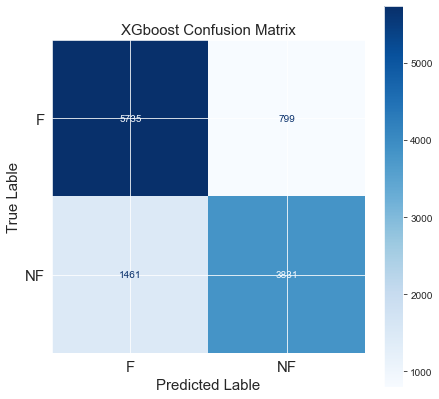

In [159]:
fig, ax = plt.subplots(figsize=(7,7))

plot_confusion_matrix(xgb_base_model, 
                      X_test_scaled, 
                      y_test,
                      ax=ax,
                     cmap=plt.cm.Blues)
plt.xticks([0,1], ['F', 'NF'], fontsize=15)
plt.xlabel('Predicted Lable', fontsize=15)
plt.ylabel('True Lable', fontsize=15)
plt.yticks([0,1], ['F', 'NF'], fontsize=15)
plt.title('XGboost Confusion Matrix', fontsize=15)
plt.savefig('images/base_cm')
plt.show()

**INTERPRETATION**
1. The basemodel has achieved much better results than many of my attempts to omptimize DT and RF
2. Perhaps adjusting weights will once again force the algorithm to predict less FN

## XGBoost v2

In [137]:
xgb_v2 = XGBClassifier()

param_grid = {
    'learning_rate' : [0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2],
    'sub_sample': [0.5, 0.7],
    
}

xgb_v2_model = GridSearchCV(estimator = xgb_v2, param_grid=param_grid, cv=3)
xgb_v2_model.fit(X_train_scaled, y_train)

[15:57:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:57:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:57:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[16:00:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:00:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:00:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[16:04:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:04:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:04:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[16:07:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:07:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:07:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

{'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'sub_sample': 0.5}
-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.87      0.94      0.90     19593
           2       0.92      0.82      0.87     15885

    accuracy                           0.89     35478
   macro avg       0.89      0.88      0.89     35478
weighted avg       0.89      0.89      0.89     35478

-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.80      0.88      0.84      6534
           2       0.83      0.73      0.78      5292

    accuracy                           0.81     11826
   macro avg       0.82      0.80      0.81     11826
weighted avg       0.81      0.81      0.81     11826



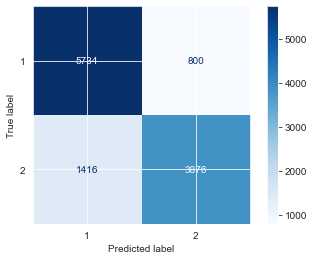

In [138]:
print(xgb_v2_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, xgb_v2_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, xgb_v2_model.predict(X_test_scaled)))

plot_confusion_matrix(xgb_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Barely any difference
2. While these results are 'good', they are not optimized for my business problem
    - going to use scale_pos_weight to attempt this 

In [139]:
xgb_v3 = XGBClassifier(sub_sample=0.5, scale_pos_weight=2, random_state=42)


param_grid = {
    'max_depth': [8, 10, 12],
    'learning_rate': [0.1, 0.075, 0.05]
}

xgb_v3_model = GridSearchCV(estimator = xgb_v3, param_grid=param_grid, cv=3)
xgb_v3_model.fit(X_train_scaled, y_train)

[16:08:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:09:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

[16:13:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=2, sub_sample=0.5,
                                     subsample=None, tree_m

{'learning_rate': 0.1, 'max_depth': 12}
-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.96      0.89      0.92     19593
           2       0.87      0.95      0.91     15885

    accuracy                           0.92     35478
   macro avg       0.92      0.92      0.92     35478
weighted avg       0.92      0.92      0.92     35478

-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.85      0.78      0.81      6534
           2       0.75      0.83      0.79      5292

    accuracy                           0.80     11826
   macro avg       0.80      0.81      0.80     11826
weighted avg       0.81      0.80      0.80     11826



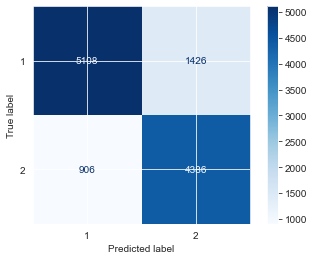

In [140]:
print(xgb_v3_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, xgb_v3_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, xgb_v3_model.predict(X_test_scaled)))

plot_confusion_matrix(xgb_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. Adjusting scale_pos_weight has made the model less likely to predict FN
2. There still seems to be some overfitting

In [141]:
xgb_v4 = XGBClassifier(sub_sample=0.5, scale_pos_weight=2, learning_rate=0.2, random_state=42)


param_grid = {
    'sub_sample' : [0.5, 0.4],
    'max_depth': [6, 7, 8]
    
}

xgb_v4_model = GridSearchCV(estimator = xgb_v4, param_grid=param_grid, cv=3)
xgb_v4_model.fit(X_train_scaled, y_train)

[16:14:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in langu

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=2, sub_sample=0.5,
                                     subsample=None, tree_me

In [142]:
print(xgb_v4_model.best_params_)
print('-------------------------------------------------------------------')
print(classification_report(y_train, xgb_v4_model.predict(X_train_scaled)))
print('-------------------------------------------------------------------')
print(classification_report(y_test, xgb_v4_model.predict(X_test_scaled)))



{'max_depth': 8, 'sub_sample': 0.5}
-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.94      0.85      0.89     19593
           2       0.83      0.93      0.88     15885

    accuracy                           0.88     35478
   macro avg       0.88      0.89      0.88     35478
weighted avg       0.89      0.88      0.88     35478

-------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.85      0.76      0.81      6534
           2       0.74      0.84      0.79      5292

    accuracy                           0.80     11826
   macro avg       0.80      0.80      0.80     11826
weighted avg       0.80      0.80      0.80     11826



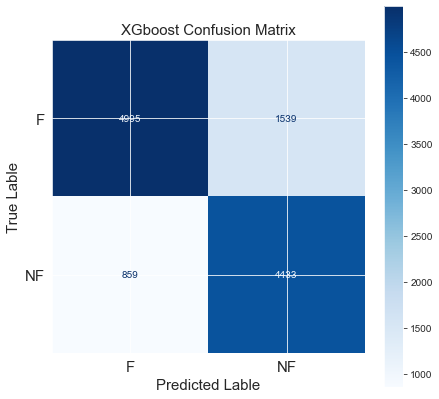

In [157]:
fig, ax = plt.subplots(figsize=(7,7))

plot_confusion_matrix(xgb_v4_model, 
                      X_test_scaled, 
                      y_test,
                      ax=ax,
                     cmap=plt.cm.Blues)
plt.xticks([0,1], ['F', 'NF'], fontsize=15)
plt.xlabel('Predicted Lable', fontsize=15)
plt.ylabel('True Lable', fontsize=15)
plt.yticks([0,1], ['F', 'NF'], fontsize=15)
plt.title('XGboost Confusion Matrix', fontsize=15)
plt.savefig('images/final_cm')
plt.show()


In [144]:
plot_feature_importances(xgb_v4_model)

NameError: name 'plot_feature_importances' is not defined

**INTERPRETATION**
1. There may be only slightly less overfitting as the test accuracy remains the same, but the train accuracy has fallen by 5%
2. FN slightly lower than previous model 
3. Compared to the best RandomForest model, recall, f1-score, and accuracy have all improved by 1% 


In [ ]:
df_map = df_binary.drop(df.columns.difference(['latitude', 'longitude', 'status_group']),1)

In [ ]:
df_map = df_map[df_map['longitude'] > 0]

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

plt.figure(figsize=(8,8))

tanz_map2 = plt.axes(projection=ccrs.PlateCarree())

tanz_map2.add_feature(cfeature.LAND)
tanz_map2.add_feature(cfeature.OCEAN)
tanz_map2.add_feature(cfeature.COASTLINE)
tanz_map2.add_feature(cfeature.BORDERS, linestyle=':')
tanz_map2.add_feature(cfeature.LAKES, alpha=0.5)
tanz_map2.add_feature(cfeature.RIVERS)
tanz_map2.add_feature(cfeature.STATES.with_scale('10m'))

scatter = plt.scatter(df_map['longitude'], df_map['latitude'], alpha=0.5,
            c=df_map['status_group'],
            cmap=plt.get_cmap("Set1"),
            transform=ccrs.PlateCarree())

red_patch= mpatches.Patch(color='red', label='Functional')
grey_patch= mpatches.Patch(color='grey', label='Non-Functional')
plt.legend(handles=[red_patch, grey_patch])




In [ ]:
plt.figure(figsize=(8,8))

tanz_map2 = plt.axes(projection=ccrs.PlateCarree())

tanz_map2.add_feature(cfeature.LAND)
tanz_map2.add_feature(cfeature.OCEAN)
tanz_map2.add_feature(cfeature.COASTLINE)
tanz_map2.add_feature(cfeature.BORDERS, linestyle=':')
tanz_map2.add_feature(cfeature.LAKES, alpha=0.5)
tanz_map2.add_feature(cfeature.RIVERS)
tanz_map2.add_feature(cfeature.STATES.with_scale('10m'))

scatter = plt.scatter(df_regions['longitude'], df_regions['latitude'], alpha=0.5,
            c=df_regions['region'],
            cmap=plt.get_cmap("Set1"),
            transform=ccrs.PlateCarree())

# red_patch= mpatches.Patch(color='red', label='Functional')
# grey_patch= mpatches.Patch(color='grey', label='Non-Functional')
# plt.legend(handles=[red_patch, grey_patch])



In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='region', hue='status_group', data=df_binary)

In [ ]:
nf_regions = ['Mara', 'Mtwara', 'Tabora', 'Rukwa', 'Kigoma', 'Lindi', 'Dodoma', 'Mbeya', 'Dar es Salaam']

for index,row in df_binary.iterrows():
    if row['region'] not in nf_regions:
        df_binary.drop(index, inplace=True)

In [ ]:
nf_regions = ['Mara', 'Mtwara', 'Tabora', 'Rukwa', 'Kigoma', 'Lindi', 'Dodoma', 'Mbeya', 'Dar es Salaam']

for index,row in df_binary.iterrows():
    if row['region'] not in nf_regions:
        df_binary.drop(index, inplace=True)

df_binary= df_binary.replace({'region': 'Mara'}, 1)
df_binary= df_binary.replace({'region': 'Mtwara'}, 2)
df_binary= df_binary.replace({'region': 'Tabora'}, 3)
df_binary= df_binary.replace({'region': 'Rukwa'}, 4)
df_binary= df_binary.replace({'region': 'Kigoma'}, 5)
df_binary= df_binary.replace({'region': 'Lindi'}, 6)
df_binary= df_binary.replace({'region': 'Dodoma'}, 7)
df_binary= df_binary.replace({'region': 'Mbeya'}, 8)
df_binary= df_binary.replace({'region': 'Dar es Salaam'}, 9)

In [ ]:
nf_regions = ['Mara', 'Mtwara', 'Tabora', 'Rukwa', 'Kigoma', 'Lindi', 'Dodoma', 'Mbeya', 'Dar es Salaam']

for index,row in df_binary.iterrows():
    if row['region'] not in nf_regions:
        df_binary.drop(index, inplace=True)

df_binary= df_binary.replace({'region': 'Mara'}, 1)
df_binary= df_binary.replace({'region': 'Mtwara'}, 2)
df_binary= df_binary.replace({'region': 'Tabora'}, 3)
df_binary= df_binary.replace({'region': 'Rukwa'}, 4)
df_binary= df_binary.replace({'region': 'Kigoma'}, 5)
df_binary= df_binary.replace({'region': 'Lindi'}, 6)
df_binary= df_binary.replace({'region': 'Dodoma'}, 7)
df_binary= df_binary.replace({'region': 'Mbeya'}, 8)
df_binary= df_binary.replace({'region': 'Dar es Salaam'}, 9)



plt.figure(figsize=(8,8))

tanz_map3 = plt.axes(projection=ccrs.PlateCarree())

tanz_map3.add_feature(cfeature.LAND)
tanz_map3.add_feature(cfeature.OCEAN)
tanz_map3.add_feature(cfeature.COASTLINE)
tanz_map3.add_feature(cfeature.BORDERS, linestyle=':')
tanz_map3.add_feature(cfeature.LAKES, alpha=0.5)
tanz_map3.add_feature(cfeature.RIVERS)
tanz_map3.add_feature(cfeature.STATES.with_scale('10m'))

scatter = plt.scatter(df_binary['longitude'], df_binary['latitude'], alpha=0.5,
            c=df_binary['region'],
            cmap=plt.get_cmap("Set1"),
            transform=ccrs.PlateCarree())

red_patch= mpatches.Patch(color='red', label='Mara')
grey_patch= mpatches.Patch(color='grey', label='Dar es Salaam')
yellow_patch = mpatches.Patch(color='yellow', label='Lindi')
blue_patch = mpatches.Patch(color='blue', label='Mwara')
brown_patch= mpatches.Patch(color='brown', label='Dodoma')
green_patch= mpatches.Patch(color='green', label='Tabora')
orange_patch= mpatches.Patch(color='orange', label='Kigoma')
purple_patch= mpatches.Patch(color='purple', label='Rukwa/Katavi')
pink_patch=mpatches.Patch(color='pink', label='Mbeya')
plt.legend(handles=[red_patch, grey_patch, yellow_patch, purple_patch, blue_patch,
                   brown_patch, green_patch, orange_patch, pink_patch]);

plt.title('Regions: Non-functional > Functional', fontsize=15);

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='scheme_management', hue='status_group', data=df_binary)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='well_age', hue='status_group', data=df_binary[(df_binary['well_age']<42)])

In [ ]:
sns.scatterplot(x='status_group', y='altitude', data=df_binary)

In [147]:
df_binary

,amount_tsh,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,population,...,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,well_age,altitude,month_recorded
0,6000.0,34.938093,-9.856322,Other,0,Lake Nyasa,Iringa,11,5,109,...,annually,good,enough,spring,groundwater,communal standpipe,1,14,1390,3
2,25.0,37.460664,-3.821329,Other,0,Pangani,Manyara,21,4,250,...,per bucket,good,enough,dam,surface,communal standpipe multiple,1,4,686,2
3,0.0,38.486161,-11.155298,Other,0,Ruvuma / Southern Coast,Mtwara,90,63,58,...,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,2,27,263,1
5,20.0,39.172796,-4.765587,Other,0,Pangani,Tanga,4,8,1,...,per bucket,salty,enough,other,unknown,communal standpipe multiple,1,4,0,3
6,0.0,33.362410,-3.766365,Other,0,Internal,Shinyanga,17,3,0,...,never pay,good,enough,machine dbh,groundwater,hand pump,2,100,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,37.634053,-6.124830,Other,0,Wami / Ruvu,Morogoro,5,6,89,...,monthly,good,enough,machine dbh,groundwater,communal standpipe,2,6,351,3
59395,10.0,37.169807,-3.253847,Other,0,Pangani,Kilimanjaro,3,5,125,...,per bucket,good,enough,spring,groundwater,communal standpipe,1,14,1210,5
59396,4700.0,35.249991,-9.070629,Other,0,Rufiji,Iringa,11,4,56,...,annually,good,enough,river,surface,communal standpipe,1,17,1212,5
59398,0.0,35.861315,-6.378573,Other,0,Rufiji,Dodoma,1,4,0,...,never pay,good,insufficient,shallow well,groundwater,hand pump,1,100,0,3
